# Analysis of movie revenue dataset 

## Importing data and intial insights:


In [1]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import random
plt.style.use("ggplot")

In [2]:
#read in data
df = pd.read_csv("tmdb_5000_movies.csv")

#removing columns which are either useless or too vague
df.drop(["overview", "popularity", "homepage", "status", "original_title", "tagline"], axis=1, inplace = True)

#adding ratio column, removing inf and nan values
df["bdgt_2_rev"] = df["revenue"] / df["budget"]
df = df.replace([np.inf, -np.inf], np.nan).dropna()
#making over 100 tuimes your budget would be very few and far between and may skew data so we remove
df = df[df["bdgt_2_rev"] <= 100] 
df.head()

,budget,genres,id,keywords,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,bdgt_2_rev
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800,11.763566
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500,3.203333
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466,3.594590
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Dark Knight Rises,7.6,9106,4.339756
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",John Carter,6.1,2124,1.092843


In [3]:
#creating dataframe for testing

num_ranints = int(len(df)/10)
rand = random.sample(range(0, len(df)), num_ranints)
rand = list(rand)

test_df = df.take(rand)

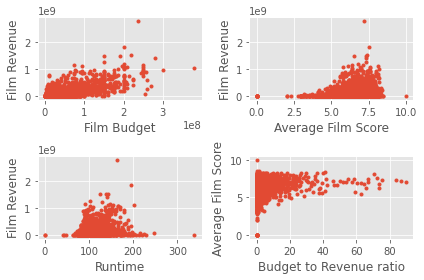

In [4]:
#inital visualizations to look into data
fig = plt.figure()

#plotting budget against revenue
ax = fig.add_subplot(2, 2, 1)
plt.plot(df["budget"], df["revenue"], marker = ".", linestyle = "")
plt.xlabel("Film Budget")
plt.ylabel("Film Revenue")

#plotting average film score against revenue
ax = fig.add_subplot(2, 2, 2)
plt.plot(df["vote_average"], df["revenue"], marker = ".", linestyle = "")
plt.xlabel("Average Film Score")
plt.ylabel("Film Revenue")

#plotting runtime against revenue
ax = fig.add_subplot(2, 2, 3)
plt.plot(df["runtime"], df["revenue"], marker = ".", linestyle = "")
plt.xlabel("Runtime")
plt.ylabel("Film Revenue")

#plotting profit ratio against average film score
ax = fig.add_subplot(2, 2, 4)
plt.plot(df["bdgt_2_rev"], df["vote_average"], marker = ".", linestyle = "")
plt.xlabel("Budget to Revenue ratio")
plt.ylabel("Average Film Score")

plt.tight_layout()
plt.show()

## Question 1:
### Can we predict movie revenue based off of budget, score and runtime?

To predict this, we will take a closer look at the approximate relationships between movie revenue and some yet to be determined numerical predictors, modify each of them into a linear relationship and then evaluate the resulting model.

In [5]:
#look at all possible correlations in our dataframe
df.corr()

,budget,id,revenue,runtime,vote_average,vote_count,bdgt_2_rev
budget,1.000000,-0.045009,0.711700,0.254607,0.020139,0.556565,-0.099914
id,-0.045009,1.000000,-0.013010,-0.087450,-0.157770,0.049557,-0.055077
revenue,0.711700,-0.013010,1.000000,0.250319,0.204160,0.767957,0.230010
runtime,0.254607,-0.087450,0.250319,1.000000,0.388154,0.276040,0.048794
vote_average,0.020139,-0.157770,0.204160,0.388154,1.000000,0.362529,0.230397
vote_count,0.556565,0.049557,0.767957,0.276040,0.362529,1.000000,0.202971
bdgt_2_rev,-0.099914,-0.055077,0.230010,0.048794,0.230397,0.202971,1.000000


From this, it would appear that it is worth at least considering all variables except id(which could never have any non-coincedental correlation with budget anyways) and bdgt_2_rev which uses the budget values anyways.

predictors = ["budget", "runtime", "vote_average", "vote_count"]

def plotting():
    for predictor in predictors:
        plt.figure()
        plt.scatter(df["revenue"], df[predictor])
        plt.show
        
plotting()

In [6]:
"""
Function takes in a list and a number of bins and returns binned_means 

Bin means is the mean value in a bin of width (list length/number of bins)

When plotted, this gives us a better idea of the shape of the relationship between variables
(difficult to tell with this many points on a graph so this gives us an idea of point density)
"""

def bin_points(exp_list, bin_nums):
    #get length of list and length of bins
    length = len(exp_list)
    bin_len = length // bin_nums

    #initialize empty list to return means
    binned_means = []

    for i in range(bin_nums):
    #make (/reset) empty list of values in each bin
        tmp_lst = []
        for j in range(bin_len):
    #index elements of input list and add to temp list
            index = i * bin_len + j
            tmp_lst.append(exp_list[index])
    #get mean of temp list and add to main list
        mean = sum(tmp_lst) / len(tmp_lst)
        binned_means.append(mean)

    return binned_means


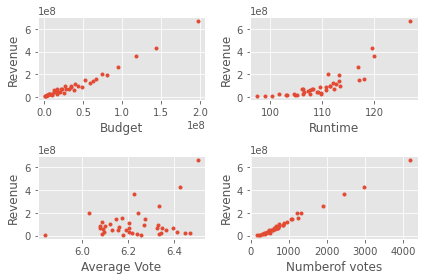

In [7]:
#plotting binned predictor values against 

rev_binned = bin_points(df["revenue"].tolist(), 40)
predictors = ["budget", "runtime", "vote_average", "vote_count"]
binned_pred = []

for lst in predictors:
    binned = bin_points(df[lst].tolist(), 40)
    binned_pred.append(binned)
    
fig = plt.figure()

#plotting budget against revenue
ax = fig.add_subplot(2, 2, 1)
plt.plot(binned_pred[0], rev_binned, marker = ".", linestyle = "")
plt.ylabel("Revenue")
plt.xlabel("Budget")

#plotting runtime score against revenue
ax = fig.add_subplot(2, 2, 2)
plt.plot(binned_pred[1], rev_binned, marker = ".", linestyle = "")
plt.ylabel("Revenue")
plt.xlabel("Runtime")

#plotting average vote against revenue
ax = fig.add_subplot(2, 2, 3)
plt.plot(binned_pred[2], rev_binned, marker = ".", linestyle = "")
plt.ylabel("Revenue")
plt.xlabel("Average Vote")

#plotting number of votes vote against revenue
ax = fig.add_subplot(2, 2, 4)
plt.plot(binned_pred[3], rev_binned, marker = ".", linestyle = "")
plt.ylabel("Revenue")
plt.xlabel("Numberof votes")

plt.tight_layout()
plt.show()
    
        


Now, looking at the relationships, we can see that budget and number of votes appear to have approximately linear relationships with revenue, runtime possibly has some sort of polynomic relationship and the average vote has no clear patterns and so we will no longer be using it as a predictor.

Therfore, we now tranform runtime by to see if we can obtain an approximately linear relationship.

Text(0.5, 0, 'Runtime')

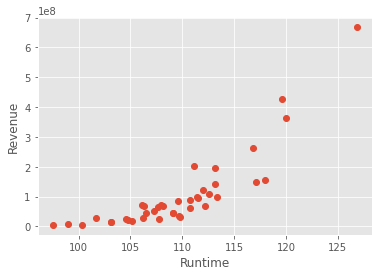

In [8]:
#enlarged view of revenue vs runtime
plt.plot(binned_pred[1], rev_binned, marker = "o", linestyle = "")
plt.ylabel("Revenue")
plt.xlabel("Runtime")

To try and find an appropriate polynomial with which to modify our data, we will fit polynomials of increasing degrees using the numpy.polyfit function. We will then assess suitability based on correlation values.

In [9]:
#empty list for correlation under modification
corrvals = []
for i in range(1, 10):    

#empty list to store modified values based off regressed polynomial
    f_runtime = []

#find best fitting polynomial of degree n and substitute in all runtime values, storing vals in list.
    coeffs = np.polyfit(df["runtime"], df["revenue"], deg = i)
    for j in df["runtime"]:
        x = np.polyval(coeffs, j)
        f_runtime.append(x)

#make new dataframe to store 
    df2 = pd.DataFrame(df["revenue"])
    df2["runtime"] = df["runtime"]
    df2["mod_runtime"] = f_runtime

#calculating and storing revenue vs modified runtime correlation
    correlations = df2.corr()
    correlations = correlations.iloc[0, 2]
    corrvals.append(correlations)
    
print(corrvals)

[0.25031863918246505, 0.2545598972690721, 0.2647453596785204, 0.2668378430961638, 0.2834860629233538, 0.2836297776637384, 0.2908050370456484, 0.29080545353476267, 0.2928795879858117]


Text(0.5, 0, 'Polynomial Degree')

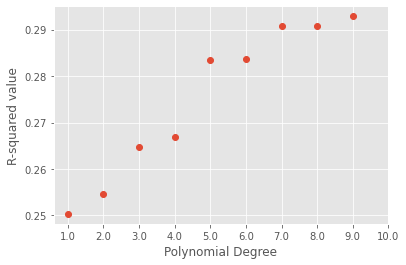

In [10]:
plt.plot(corrvals, marker = "o", linestyle = "")
plt.ylabel("R-squared value")
labels = np.linspace(1, 10, 10, dtype = "str")
plt.xticks(np.linspace(0, 9, 10), labels)
plt.xlabel("Polynomial Degree")


Therefore, we can see that the largest improvement (by far) happens between polynomials of degrees 3 and 4. This is also ideal is the polynomial we are using is not too heavily fitted (degree 4 polynomial for approximatly 3700 data points). As a result of this, wee will plug in all runtime values into this function and use the resultant values for our final model to give greater confidence.
From now on, we will use the column f_runtime (f(runtime)) instead of runtime in our model.

In [14]:
#looking at our runtime funtion

coeffs = np.polyfit(df["runtime"], df["revenue"], deg = 4)
print(coeffs)

[ 4.87411823e-01 -4.19571178e+02  1.08704739e+05 -8.66209007e+06
  2.29646084e+08]


In [12]:
#making dataframe column for f(runtime)
f_runtime = []
for i in df["runtime"]:
    x = np.polyval(coeffs, i)
    f_runtime.append(x)

df["f_runtime"] = f_runtime
df.head()

,budget,genres,id,keywords,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,bdgt_2_rev,f_runtime
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800,11.763566,2.311197e+08
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500,3.203333,2.428758e+08
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466,3.594590,2.024159e+08
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Dark Knight Rises,7.6,9106,4.339756,2.363915e+08
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",John Carter,6.1,2124,1.092843,1.632975e+08


#renaming list and taking log of revenue
sqrt_rev_binned = [np.sqrt(x) for x in rev_binned]
log_rev_binned = [np.log(x) for x in rev_binned]
rt = binned_pred[1]
rt2 = [(1/5)*x**(1/2) for x in rt]

#plotting fixed data to look for approximately linear relationship
plt.plot(rev_binned, rt, marker = "o", linestyle = "")
plt.xlabel("Log Revenue")
plt.ylabel("Runtime")
plt.show()

plt.plot(rev_binned, rt2, marker = "o", linestyle = "")
plt.xlabel("Log Revenue")
plt.ylabel("Runtime")
plt.show()


x = df["runtime"]
y = df["revenue"]

fit = np.polyfit(x, y, deg = 2)
mod_runtime = [fit[0]*x**2 + fit[1]*x + fit[2] for x in df["runtime"]]

df2 = pd.DataFrame(df["revenue"])
df2["runtime"] = df["runtime"]
df2["mod_runtime"] = mod_runtime
df2.corr()


